In [1]:
using Revise

In [2]:
using OpticalBlochEquations, QuantumStates

┌ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
└ @ Base loading.jl:1423


In [3]:
using Plots
using BenchmarkTools
using DifferentialEquations
using LinearAlgebra

### Construct the $\text{X}^2\Sigma^+(N = 1)$ state in Hund's case (b) basis

In [53]:
# Spectroscopic constants for CaF, X state

# From Luke Caldwell's thesis (2020)
# Units are MHz
Be_X = 10303.988
De_X = 0.014060
γSR_X = 39.65891
b_X = 109.1839
c_X = 40.1190
;

In [54]:
gS = 2
μB = 1.39962
;

In [55]:
QN_bounds = (S = 1//2, I = 1//2, Λ = -1:1, N = 0:3)
basis_X = enumerate_states(HundsCaseB_Rot, QN_bounds)
ordered_basis_X = order(basis_X, :M)
;

In [56]:
H_X_operator = 
    Be_X * Rotation + 
    De_X * RotationDistortion + 
    γSR_X * SpinRotation + 
    (b_X + c_X/3) * Hyperfine_IS + 
    (c_X/3) * Hyperfine_Dipolar +
    0.00001 * μB * gS * Zeeman
;

In [57]:
H_X = Hamiltonian(basis=ordered_basis_X, H_operator=H_X_operator)
update_matrix!(H_X)
es_X, vs_X = eigen(H_X.M)
states_X = states_from_basis(ordered_basis_X, es_X, vs_X)
;

In [58]:
states_X_N1 = subspace(states_X, (Λ = 0, N = 1,))
;

### Construct $\text{A}^2 \Pi_{1/2}(J' = 1/2, \text{parity} = e)$ state in Hund's case (a) basis

In [59]:
# Spectroscopic constants for CaF, A state

# From Kaledin et al. (1998)
T_A = 16526.750 * c * 1e-4
Be_A = 0.34248818 * c * 1e-4
Aso_A = 71.429 * c * 1e-4
b00_A = -4.8
p_A = -1334.6
q_A = -8.742
;

In [60]:
QN_bounds = (S = 1/2, I = 1/2, Λ = [-1, 1], J = 1/2:3/2)
basis_A = enumerate_states(HundsCaseA_Rot, QN_bounds)
ordered_basis_A = order(basis_A, :M)
;

In [61]:
H_A_operator = 
    T_A * DiagonalOperator +
    Be_A * Rotation + 
    Aso_A * SpinOrbit + 
    q_A * ΛDoubling_q +
    (p_A + 2q_A) * ΛDoubling_p2q +
    b00_A * (Hyperfine_IF - Hyperfine_IL)
;

In [62]:
H_A = Hamiltonian(basis=ordered_basis_A, H_operator=H_A_operator)
update_matrix!(H_A)
es_A, vs_A = eigen(H_A.M)
states_A = states_from_basis(ordered_basis_A, es_A, vs_A)
;

In [63]:
states_A_J12 = subspace(states_A, (J = 1/2,))

# Pick out only the states of positive parity
states_A_J12 = states_A_J12[5:8]
;

In [64]:
states_A_J12_caseB = convert_basis(states_A_J12, ordered_basis_X)
;

In [65]:
states = [states_X_N1; states_A_J12_caseB]
;

### Calculate transition dipole moments between the two states

In [72]:
d = zeros(length(states), length(states), 3)
for (i, X_state) in enumerate(states)
    for (j, A_state) in enumerate(states)
        for p in -1:1
            d[i,j,p+2] = round(TDM(X_state, A_state, p), digits=10)
            d[j,i,p+2] = d[i,j,p+2]
        end
    end
end
;

In [73]:
# Wigner D-matrix to rotate polarization vector
D(cosβ, sinβ, α, γ) = [
    (1/2)*(1 + cosβ)*exp(-im*(α + γ)) -(1/√2)*sinβ*exp(-im*α) (1/2)*(1 - cosβ)*exp(-im*(α - γ));
    (1/√2)*sinβ*exp(-im*γ) cosβ -(1/√2)*sinβ*exp(im*γ);
    (1/2)*(1 - cosβ)*exp(im*(α - γ)) (1/√2)*sinβ*exp(im*α) (1/2)*(1 + cosβ)*exp(im*(α + γ))
]

function rotate_pol(pol, k)
    # Rotates polarization `pol` onto the quantization axis `k`
    k = k / norm(k)
    cosβ = k[3]
    sinβ = sqrt(1 - cosβ^2)
    α = 0.0
    if abs(cosβ) < 1
        γ = atan(k[2], k[1])
    else
        γ = 0.0
    end
    return inv(D(cosβ, sinβ, α, γ)) * pol
end;

In [74]:
function find_idx_for_time(time_to_find, times, backwards)
    if backwards
        times = reverse(times)
    end
    start_time = times[1]
    found_idx = 0
    for (i, time) in enumerate(times)
        if abs(start_time - time) > time_to_find
            found_idx = i
            break
        end
    end
    if backwards
        found_idx = length(times) + 1 - found_idx
    end
    
    return found_idx
end;

In [75]:
function calculate_force_from_period(p, sol, force_idxs)
    """
    Integrates the force resulting from `sol` over a time period designated by `period`.
    """
    force = 0.0
    for i in force_idxs
        force += OpticalBlochEquations.force(p, sol.u[i], sol.t[i])
    end
    t = sol.t[force_idxs[end]] - sol.t[force_idxs[1]]
    return force / (length(force_idxs))
end;

In [76]:
function sample_directions(n)
    """
    Sample `n` random directions in the form of vectors.
    (Following `https://math.stackexchange.com/questions/44689/how-to-find-a-random-axis-or-unit-vector-in-3d`.)
    """
    θs = 2π .* rand(n)
    zs = 2 .* rand(n) .- 1
    
    return [SVector(sqrt(1 - z^2) * cos(θ), sqrt(1 - z^2) * sin(θ), z) for (θ,z) in zip(θs,zs)]
end
;

In [77]:
function sample_positions(n)
    xs = rand(n) * λ
    ys = rand(n) * λ
    zs = rand(n) * λ
    
    return [SVector(x,y,z) for (x,y,z) in zip(xs,ys,zs)]
end
;

In [78]:
const λ = @with_unit 606.3 "nm"
const Γ = @with_unit 2π * 8.3 "MHz"
const M = @with_unit 50 "u"
const E₀ = c / λ
const ω = 2π * E₀
const k = ω / c
Is = 4.9 # saturation intensity for CaF X-A transition, in mW/cm^2
;

In [79]:
# Convert all energies to angular units 
states_angularE = deepcopy(states)
for state in states_angularE
    state.E = 2π * state.E * 1e6
end

In [80]:
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

lin_x = (1/√2) * [1, 0, -1]
lin_y = (im/√2) * [1, 0, 1]
lin_z = [0., 1., 0.]
;

In [178]:
# Single-frequency cooling
# Scheme "(III)" in "Deep laser cooling and efficient magnetic compression of molecules (Caldwell, 2019)"

δf = +Γ
s = 340 / Is / 6 # Divide by number of lasers

f = (states_angularE[end].E - states_angularE[1].E) + δf

l1 = Laser(-x, rotate_pol(σ_p, -x), f, s)
l2 = Laser(+x, rotate_pol(σ_p, +x), f, s)

l3 = Laser(-y, rotate_pol(σ_p, -y), f, s)
l4 = Laser(+y, rotate_pol(σ_p, +y), f, s)

l5 = Laser(-z, rotate_pol(σ_p, -z), f, s)
l6 = Laser(+z, rotate_pol(σ_p, +z), f, s)

SF_lasers = [l1, l2, l3, l4, l5, l6]
SF_lasers_1D = [l5, l6]
SF_lasers_2D = [l3, l4, l5, l6]
;

In [179]:
# Lambda-cooling
δf = +Γ
s = 340 / Is / 12 # Divide by number of lasers

f1 = (states_angularE[end].E - states_angularE[1].E) + δf

l1 = Laser(-x, rotate_pol(σ_m, -x), f1, s)
l2 = Laser(+x, rotate_pol(σ_p, +x), f1, s)

l3 = Laser(-y, rotate_pol(σ_m, -y), f1, s)
l4 = Laser(+y, rotate_pol(σ_p, +y), f1, s)

l5 = Laser(-z, rotate_pol(σ_m, -z), f1, s)
l6 = Laser(+z, rotate_pol(σ_p, +z), f1, s)

f2 = (states_angularE[end].E - states_angularE[10].E) + δf

l7 = Laser(-x, rotate_pol(σ_m, -x), f2, s)
l8 = Laser(+x, rotate_pol(σ_p, +x), f2, s)

l9 = Laser(-y, rotate_pol(σ_m, -y), f2, s)
l10 = Laser(+y, rotate_pol(σ_p, +y), f2, s)

l11 = Laser(-z, rotate_pol(σ_m, -z), f2, s)
l12 = Laser(+z, rotate_pol(σ_p, +z), f2, s)

Λ_lasers = [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12]
Λ_lasers_1D = [l5, l6, l11, l12]
;

In [180]:
# linϕlin polarization
ϕ = π/2

l1 = Laser(-x, lin_z, f, s)
l2 = Laser( x, lin_z * cos(ϕ) + lin_y * sin(ϕ), f, s)

l3 = Laser(-y, lin_x, f, s)
l4 = Laser( y, lin_x * cos(ϕ) + lin_z * sin(ϕ), f, s)

l5 = Laser(-z, lin_y, f, s)
l6 = Laser( z, lin_y * cos(ϕ) + lin_x * sin(ϕ), f, s)

lasers_linϕlin_1D = [l5, l6]
lasers_linϕlin = [l1, l2, l3, l4, l5, l6]
;

In [234]:
lasers = SF_lasers_1D
;

In [242]:
using StaticArrays

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

# Frequencies are rounded to a multiple of `freq_res`, and are measured in units of Γ
freq_res = 1e-3

(dρ, ρ, p) = obe(states_angularE, lasers, d, ρ0, Γ, freq_res=freq_res)
ρ!(dρ, ρ, p, 0.0)

ω_min = freq_res
period = 2π / ω_min
display(period)

6283.185307179586

In [243]:
# @btime ρ!($dρ, $ρ, $p, $1.0)

In [244]:
p.particle.r0 = sample_positions(1)[1] ./ (1 / k)
p.particle.v = SVector(0.0, 0.1, 0.1) / (Γ / k)
p.particle.v = round_vel(p.particle.v, λ, Γ, freq_res)
println(p.particle.v * (Γ / k))

[0.0, 0.10129577057640003, 0.10129577057640003]


In [257]:
t_end = 2π * 8000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 100000)

prob = ODEProblem(ρ!, ρ0, tspan, p, callback=AutoAbstol(false, init_curmax=0.0))
@time sol = DifferentialEquations.solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-5, dense=false, saveat=times)
;

  9.521938 seconds (383.72 k allocations: 995.673 MiB, 24.49% gc time)


In [258]:
offset = 2000
period_idx = find_idx_for_time(period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)
force = calculate_force_from_period(p, sol, force_idxs)

println("Excited population: ", real(sum(diag(mean(sol.u[force_idxs]))[13:end])))
println("Force: ", force)
println("Acceleration (10^3 m/s^2): ", 10^(-3) * ħ * k * Γ * force / M)

Excited population: 8.252495369926889e-5
Force: -0.00016497342342946806
Acceleration (10^3 m/s^2): -0.11324559210914631


In [273]:
diag(sol.u[end])

16-element Vector{ComplexF64}:
  0.00011083597601711745 + 0.0im
 -0.00010028414246349847 + 0.0im
  0.00014660370124047647 + 0.0im
   0.0019009501618463534 + 0.0im
     0.01255741789942172 + 0.0im
     0.02742735271657212 + 0.0im
    0.006243712858904925 + 0.0im
     0.02258008866371408 + 0.0im
     0.11611315219427225 + 0.0im
      0.1892030463028942 + 0.0im
      0.3504001051474841 + 0.0im
     0.27333750085748504 + 0.0im
   2.0019365495819136e-5 + 0.0im
   -6.318054744189276e-6 + 0.0im
   1.8680867015800176e-5 + 0.0im
    4.713548481600243e-5 + 0.0im

In [264]:
diag(sol.u[end-offset].^2 - sol.u[period_idx-offset].^2) |> sum

0.0016883364779607263 + 0.0im

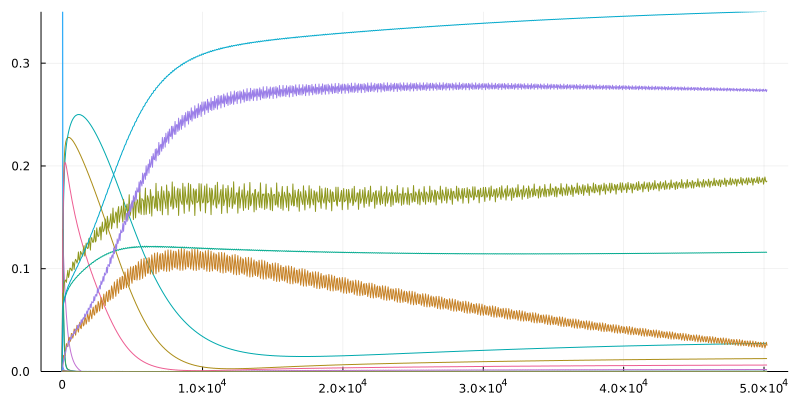

In [265]:
idxs_to_plot = force_idxs[1:100:end]
# plot_us = sol.u[idxs_to_plot]
# plot_ts = sol.t[idxs_to_plot]
plot_us = sol.u[1:100:end]
plot_ts = sol.t[1:100:end]

plot(plot_ts, [real(u[1,1]) for u in plot_us], size=(800, 400), ylim=(0, 0.35))
for i in 2:16
    plot!(plot_ts, [real(u[i,i]) for u in plot_us])
end
plot!(legend=nothing)

In [266]:
using ProgressMeter

In [267]:
# Averaging options
n_samples = 1
;

In [268]:
vs = [0.0:0.002:0.04; 0.041:0.02:0.2; 0.21:0.1:1.0]
forces = zeros(n_samples, length(vs))
exc_pop = zeros(n_samples, length(vs))

t_end = 2π * 4000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 100000)

freq_res = 1e-3
ω_min = freq_res
period = 2π / ω_min

@time begin
    @showprogress for (i, (position, direction)) ∈ enumerate(zip(sample_positions(n_samples), sample_directions(n_samples)))
        Threads.@threads for j ∈ eachindex(vs)

            v = vs[j]

            p_ = deepcopy(p)

            p_.particle.r0 = position ./ (1 / k)
            p_.particle.v = direction .* v
            p_.particle.v = round_vel(p_.particle.v * (Γ / k), λ, Γ, freq_res)

            vs[j] = sqrt(sum(p_.particle.v.^2)) / (Γ / k)

            ρ0 = zeros(ComplexF64,(length(states), length(states)))
            ρ0[1,1] = 1.0

            prob = ODEProblem(ρ!, ρ0, tspan, p_)
            sol = DifferentialEquations.solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-5, dense=false, saveat=times)

            offset = 200
            period_idx = find_idx_for_time(period, sol.t, true)
            force_idxs = (period_idx - offset):(length(times) - offset)

            force = calculate_force_from_period(p_, sol, force_idxs)

            forces[i,j] = force
            exc_pop[i,j] = real(sum(diag(mean(sol.u[force_idxs]))[13:end]))

        end
    end
end
forces[:,1] .= 0.0
forces_SI = (10^(-3) * ħ * k * Γ * forces / M)
;

138.437831 seconds (5.85 M allocations: 18.445 GiB, 27.38% gc time, 0.06% compilation time)


In [269]:
mean_exc_pop = mean(exc_pop, dims=1)'
mean_forces_SI = mean(forces_SI, dims=1)'
;

In [270]:
mean_exc_pop[1] = 0.00001

1.0e-5

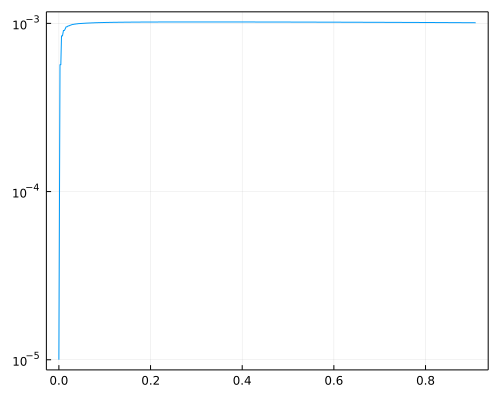

In [271]:
plot(vs, mean_exc_pop, 
    size=(500, 400),
    legend=nothing, 
    yaxis=:log, 
    #ylims=(3e-6, 3e-2),
    yticks=[1e-5, 1e-4, 1e-3, 1e-2],
    framestyle = :box
)

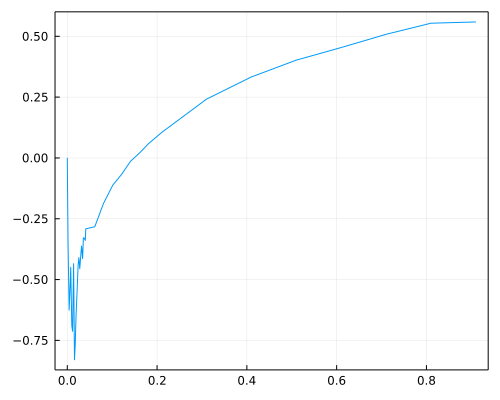

In [233]:
plot(vs, mean_forces_SI, 
    size=(500,400), 
    legend=nothing, 
    ylim=[minimum([0; forces_SI]), maximum([0; forces_SI])],
    framestyle = :box
)

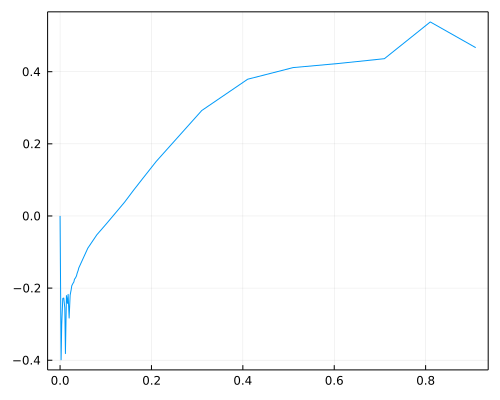

In [217]:
plot(vs, mean_forces_SI, 
    size=(500,400), 
    legend=nothing, 
    ylim=[minimum([0; forces_SI]), maximum([0; forces_SI])],
    framestyle = :box
)

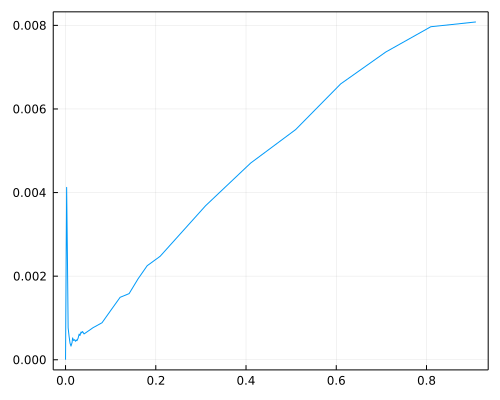

In [272]:
plot(vs, mean_forces_SI, 
    size=(500,400), 
    legend=nothing, 
    ylim=[minimum([0; forces_SI]), maximum([0; forces_SI])],
    framestyle = :box
)